## Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import torch
from torch.utils.data import DataLoader, Dataset
from glob import glob
import os
import torch.nn as nn
import torch.optim as optim
import random
from IPython.display import HTML
from base64 import b64encode
import torch.nn.functional as F
from tqdm.notebook import tqdm
import gc
import shutil
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pywt
from scipy.signal import freqz
from scipy.signal import butter, lfilter, convolve, boxcar
from scipy.signal import freqz
from sklearn.decomposition import PCA
from scipy.fftpack import fft, ifft
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/CIS520/grasp-and-lift-eeg-detection'

## Data Exploration

#### Data Collection process

In [ ]:
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

- There are 12 subjects
- Each subject records 10 series of experiments
- Each series include 6 different actions: HandStart, FirstDigitTouch, BothStartLoadPhase, LiftOff, Replace, BothReleased
- Series 1 to 8 are used for training
- Series 9 and 10 are used for testing on Kaggle

#### Data samples

In [ ]:
train_set_labels = pd.read_csv("train/subj1_series1_events.csv")
train_set_signals = pd.read_csv("train/subj1_series1_data.csv")
train_set_signals.head()

,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,TP9,CP5,CP1,CP2,CP6,TP10,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,subj1_series1_0,-31,363,211,121,211,15,717,279,35,158,543,-166,192,230,573,860,128,59,272,473,325,379,536,348,383,105,607,289,459,173,120,704
1,subj1_series1_1,-29,342,216,123,222,200,595,329,43,166,495,-138,201,233,554,846,185,47,269,455,307,368,529,327,369,78,613,248,409,141,83,737
2,subj1_series1_2,-172,278,105,93,222,511,471,280,12,177,534,-163,198,207,542,768,145,52,250,452,273,273,511,319,355,66,606,320,440,141,62,677
3,subj1_series1_3,-272,263,-52,99,208,511,428,261,27,180,525,-310,212,221,542,808,115,41,276,432,258,241,521,336,356,71,568,339,437,139,58,592
4,subj1_series1_4,-265,213,-67,99,155,380,476,353,32,165,507,-320,242,230,545,865,180,89,288,444,275,275,550,324,346,76,547,343,446,171,67,581


#### EEG data visualization with labels

HandStart = red
FirstDigitTouch = purple
BothStartLoadPhase = black
LiftOff = green
Replace = yellow
BothReleased = blue


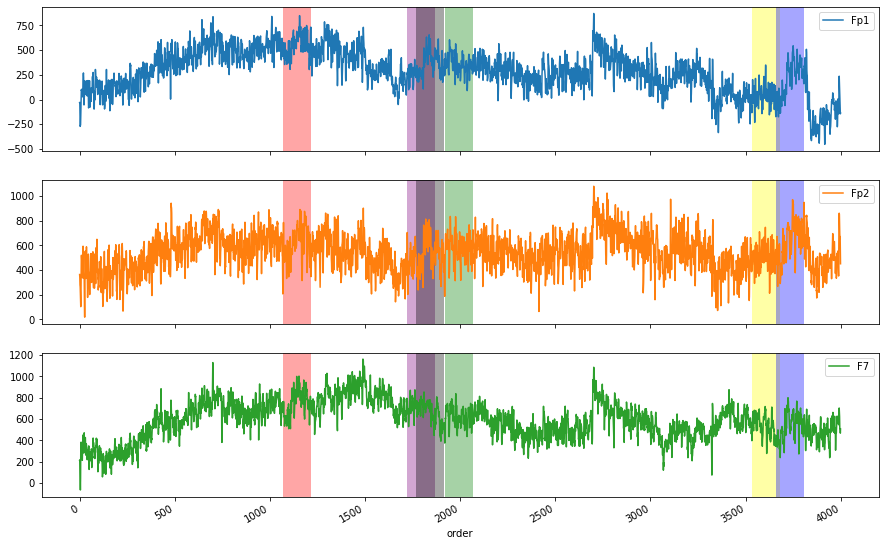

In [ ]:
eeg_channels = train_set_signals.columns.drop('id')
labels = train_set_labels.columns.drop('id')
train_set_complete = pd.concat([train_set_signals,train_set_labels], axis=1)
train_set_complete.insert(0, "order", range(0, len(train_set_complete)))
train_set_complete.head()
def highlight(indices,ax,color):
    i=0
    while i<len(indices):
        ax.axvspan(indices[i]-0.5, indices[i]+0.5, facecolor=color, edgecolor='none', alpha=.35)
        i+=1
secondsToShow = 8
channelsToShow = 3
labelsToShow = 6

sample_set = train_set_complete[train_set_complete["order"] < secondsToShow*500].drop("id", axis=1).set_index("order") #sample rate is 500hz 
colors=["red","purple","black","green", "yellow", "blue"]
axes = sample_set.plot(y=eeg_channels[:channelsToShow],subplots=True, figsize=(15,10))
for i in range(0, len(labels)):
    print(labels[i], "=", colors[i])
    
for axis in axes:    
    colorindex = 0
    for label in labels[:labelsToShow]:
        highlight(sample_set[sample_set[label]==1].index, axis, colors[colorindex])        
        colorindex = colorindex + 1
plt.show()

## Data Pre-processing

In [ ]:
def butter_lowpass_filter(data, lowcut, fs, order):
    b, a = butter(order, lowcut/(0.5*fs), btype='lowpass')
    y = lfilter(b, a, data)
    return y

def wavelet_denoising(x, wavelet='db2', level=3):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * np.mean(np.absolute(coeff[-level] - np.mean(coeff[-level], None)), None)
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')[:len(x)]

def prepare_data(fname, train_flag):
    if train_flag:
      data = pd.read_csv(fname)
      labels= pd.read_csv(fname.replace('_data','_events'))
      data=data.drop(['id' ], axis=1)
      labels=labels.drop(['id' ], axis=1)
      return  data, labels
    else:
      data = pd.read_csv(fname)
      return data

def plot_roc(y_true, y_pred):
    fig, axs = plt.subplots(3, 2, figsize=(15,13))
    for i, label in enumerate(labels):
        fpr, tpr, _ = metrics.roc_curve(y_true[i], y_pred[i])
        ax = axs[i//2, i%2]
        ax.plot(fpr, tpr)
        ax.set_title(label+" ROC")
        ax.plot([0, 1], [0, 1], 'k--')

def stack_butter_features(X): # Creating features and stacking them
    for col in [0, 1, 2]: # 3 most informative features chosen from PCA 
        F = []
        for fc in np.linspace(0,1,11)[1:]:
          b, a = butter(3, fc/250, btype="lowpass")
          F.append(lfilter(b, a, X[:, col]).reshape(-1,1))
        F = np.concatenate(F, axis=1)
        X = np.concatenate((X, F, F**2), axis=1)
    return X

In [ ]:
scaler = StandardScaler()
cols = ['HandStart','FirstDigitTouch',
        'BothStartLoadPhase','LiftOff',
        'Replace','BothReleased']
subjects = range(1,13)
downsample = 100

## Code walkthrough

This has been performed in section 10 in the CNN implementation so that it is easier to follow.

## Different model implementations on processed data

### 1. Logistic Regression

In [ ]:
ids_tot = []
pred_tot = []
y_list = []
pred_train_tot = []
preproc_mode = 2
for subject in subjects:
    X_train_denoised = []
    X_test_denoised = []
    y_raw= []
    raw = []
    fnames = sorted(glob('train/subj%d_series*_data.csv' % (subject)))
    for fname in fnames:
      data,labels=prepare_data(fname, True)
      raw.append(data)
      y_raw.append(labels)
        
    tnames = sorted(glob('test/subj%d_series*_data.csv' % (subject)))
    raw_t = []
    idx = []
    for fname in tnames:
      data = prepare_data(fname, False)
      raw_t.append(data)
      idx.append(np.array(data['id']))

    X_test= pd.concat(raw_t)
    ids=np.concatenate(idx)
    ids_tot.append(ids)
   
    X_test = X_test.drop(['id'], axis=1)
    X_test = np.asarray(X_test.astype(float))
    X_train = np.asarray(pd.concat(raw).astype(float))
    y_train = np.asarray(pd.concat(y_raw).astype(float))
    y_list.append(y_train)

    fs = 500.0
    lowcut = 7.0
    highcut = 30.0
    
    if (preproc_mode == 0):
      for i in range(0,32):      #Butter lowpass filter
          X_train_denoised.append(butter_lowpass_filter(X_train[:,i], lowcut, fs, order=3))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(butter_lowpass_filter(X_test[:,i], lowcut, fs, order=3))
          X_test_denoised = np.array(X_test_denoised).T
    elif (preproc_mode == 1):
      for i in range(0,32):      #Wavelet denoising
          X_train_denoised.append(wavelet_denoising(X_train[:,i]))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(wavelet_denoising(X_test[:,i]))
          X_test_denoised = np.array(X_test_denoised).T
    else:   #Stack butter features
      X_train_denoised = stack_butter_features(X_train)
      X_test_denoised = stack_butter_features(X_test)
        
    X_train = scaler.fit_transform(X_train_denoised)
    X_test = scaler.transform(X_test_denoised)

    lr = LogisticRegression()
    pred = np.empty((X_test.shape[0], 6))
    pred_t = np.empty((X_train.shape[0], 6))

    for i in range(6):
      y = y_train[:, i]
      print('Train subject %d, class %s' % (subject, cols[i]))
      lr.fit(X_train[::downsample,:],y[::downsample])
      pred[:,i] = lr.predict_proba(X_test)[:,1]
      pred_t[:, i] = lr.predict_proba(X_train)[:,1]
    pred_train_tot.append(pred_t)
    pred_tot.append(pred)

#### ROC curves of training data

AUC ROC score :  0.9048783058758452


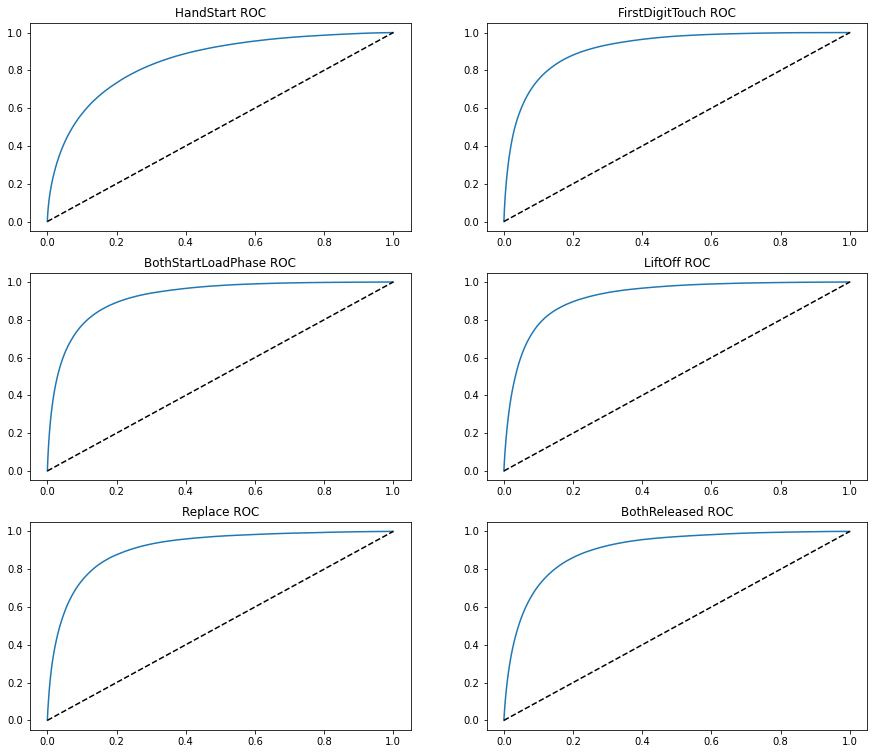

In [ ]:
y_pred = np.concatenate(pred_train_tot, axis=0)
y_true = np.concatenate(y_list, axis=0)
plot_roc(y_true.T, y_pred.T)
print('AUC ROC score : ', metrics.roc_auc_score(y_true, y_pred))

In [ ]:
try:
  !rm submission.csv
except:
  pass
submission = pd.DataFrame(index=np.concatenate(ids_tot),
                          columns=cols,
                          data=np.concatenate(pred_tot))
submission.to_csv('submission.csv',index_label='id',float_format='%.3f')
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions submit -c grasp-and-lift-eeg-detection -f submission.csv -m "Logistic Regression with stacked butter"

100% 171M/171M [00:12<00:00, 14.4MB/s]
Successfully submitted to Grasp-and-Lift EEG Detection

#### ROC Score for hidden data on Kaggle: 0.87406




###2. Linear Discriminant Analysis

In [ ]:
ids_tot = []
pred_tot = []
y_list = []
pred_train_tot = []
preproc_mode = 2

for subject in subjects:
    X_train_denoised = []
    X_test_denoised = []
    y_raw= []
    raw = []
    fnames = sorted(glob('train/subj%d_series*_data.csv' % (subject)))
    for fname in fnames:
      data,labels=prepare_data(fname, True)
      raw.append(data)
      y_raw.append(labels)
        
    tnames = sorted(glob('test/subj%d_series*_data.csv' % (subject)))
    raw_t = []
    idx = []
    for fname in tnames:
      data = prepare_data(fname, False)
      raw_t.append(data)
      idx.append(np.array(data['id']))

    X_test= pd.concat(raw_t)
    ids=np.concatenate(idx)
    ids_tot.append(ids)
   
    X_test = X_test.drop(['id'], axis=1)
    X_test = np.asarray(X_test.astype(float))
    X_train = np.asarray(pd.concat(raw).astype(float))
    y_train = np.asarray(pd.concat(y_raw).astype(float))
    y_list.append(y_train)
    
    fs = 500.0
    lowcut = 7.0
    
    if (preproc_mode == 0):
      for i in range(0,32):      #Butter lowpass filter
          X_train_denoised.append(butter_lowpass_filter(X_train[:,i], lowcut, fs, order=3))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(butter_lowpass_filter(X_test[:,i], lowcut, fs, order=3))
          X_test_denoised = np.array(X_test_denoised).T
    elif (preproc_mode == 1):
      for i in range(0,32):      #Wavelet denoising
          X_train_denoised.append(wavelet_denoising(X_train[:,i]))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(wavelet_denoising(X_test[:,i]))
          X_test_denoised = np.array(X_test_denoised).T
    else:   #Stack butter features
      X_train_denoised = stack_butter_features(X_train)
      X_test_denoised = stack_butter_features(X_test)

    X_train = scaler.fit_transform(X_train_denoised)
    X_test = scaler.transform(X_test_denoised)

    lda = LDA()
    pred = np.empty((X_test.shape[0], 6))
    pred_t = np.empty((X_train.shape[0], 6))

    for i in range(6):
      y = y_train[:, i]
      print('Train subject %d, class %s' % (subject, cols[i]))
      lda.fit(X_train[::downsample,:],y[::downsample])
      pred[:,i] = lda.predict_proba(X_test)[:,1]
      pred_t[:, i] = lda.predict_proba(X_train)[:,1]
    pred_train_tot.append(pred_t)
    pred_tot.append(pred)

NameError: ignored

#### ROC Curves of training data

AUC ROC score :  0.9100582233718292


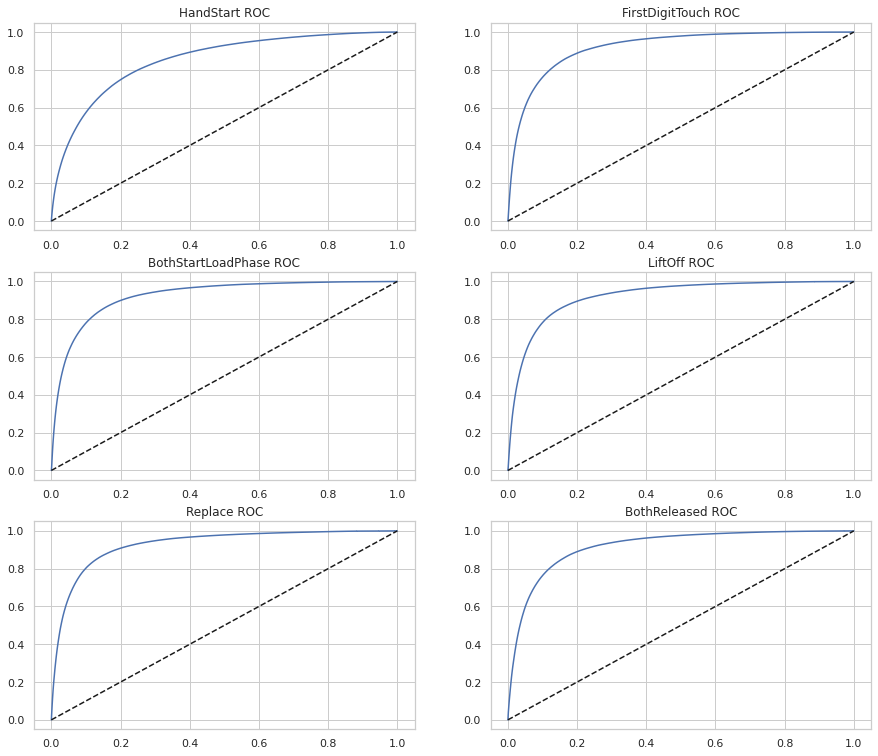

In [ ]:
y_pred = np.concatenate(pred_train_tot, axis=0)
y_true = np.concatenate(y_list, axis=0)
plot_roc(y_true.T, y_pred.T)
print('AUC ROC score : ', metrics.roc_auc_score(y_true, y_pred))

In [ ]:
try:
  !rm submission.csv
except:
  pass
submission = pd.DataFrame(index=np.concatenate(ids_tot),
                          columns=cols,
                          data=np.concatenate(pred_tot))
submission.to_csv('submission.csv',index_label='id',float_format='%.3f')
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions submit -c grasp-and-lift-eeg-detection -f submission.csv -m "LDA with triple stacked butter"

100% 171M/171M [00:10<00:00, 16.7MB/s]
Successfully submitted to Grasp-and-Lift EEG Detection

#### ROC Score for hidden data on Kaggle: 0.88596

### 3. Quadratic Discriminant Analysis 

In [ ]:
ids_tot = []
pred_tot = []
y_list = []
pred_train_tot = []
preproc_mode = 2

for subject in subjects:
    X_train_denoised = []
    X_test_denoised = []
    y_raw= []
    raw = []
    fnames = sorted(glob('train/subj%d_series*_data.csv' % (subject)))
    for fname in fnames:
      data,labels=prepare_data(fname, True)
      raw.append(data)
      y_raw.append(labels)
        
    tnames = sorted(glob('test/subj%d_series*_data.csv' % (subject)))
    raw_t = []
    idx = []
    for fname in tnames:
      data = prepare_data(fname, False)
      raw_t.append(data)
      idx.append(np.array(data['id']))

    X_test= pd.concat(raw_t)
    ids=np.concatenate(idx)
    ids_tot.append(ids)
   
    X_test = X_test.drop(['id'], axis=1)
    X_test = np.asarray(X_test.astype(float))
    X_train = np.asarray(pd.concat(raw).astype(float))
    y_train = np.asarray(pd.concat(y_raw).astype(float))
    y_list.append(y_train)
    
    fs = 500.0
    lowcut = 7.0
    
    if (preproc_mode == 0):
      for i in range(0,32):      #Butter lowpass filter
          X_train_denoised.append(butter_lowpass_filter(X_train[:,i], lowcut, fs, order=3))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(butter_lowpass_filter(X_test[:,i], lowcut, fs, order=3))
          X_test_denoised = np.array(X_test_denoised).T
    elif (preproc_mode == 1):
      for i in range(0,32):      #Wavelet denoising
          X_train_denoised.append(wavelet_denoising(X_train[:,i]))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(wavelet_denoising(X_test[:,i]))
          X_test_denoised = np.array(X_test_denoised).T
    else:   #Stack butter features
      X_train_denoised = stack_butter_features(X_train)
      X_test_denoised = stack_butter_features(X_test)
 

    X_train = scaler.fit_transform(X_train_denoised)
    X_test = scaler.transform(X_test_denoised)

    qda = QDA()
    pred = np.empty((X_test.shape[0], 6))
    pred_t = np.empty((X_train.shape[0], 6))

    for i in range(6):
      y = y_train[:, i]
      print('Train subject %d, class %s' % (subject, cols[i]))
      qda.fit(X_train[::downsample,:],y[::downsample])
      pred[:,i] = qda.predict_proba(X_test)[:,1]
      pred_t[:, i] = qda.predict_proba(X_train)[:,1]
    pred_train_tot.append(pred_t)
    pred_tot.append(pred)

#### ROC Curves of training data

AUC ROC score :  0.9023431918470233


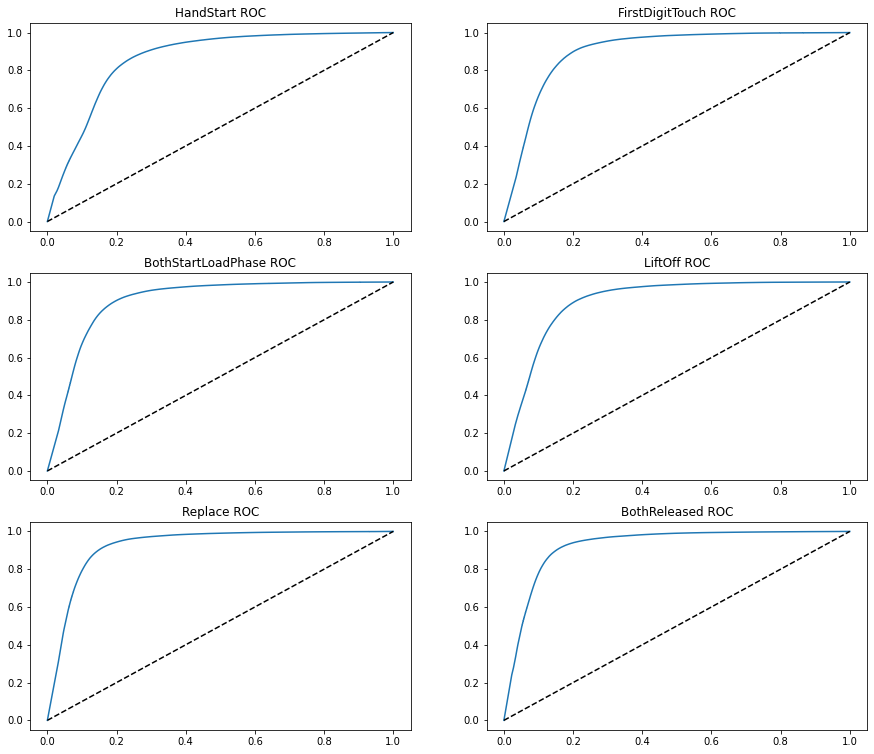

In [ ]:
y_pred = np.concatenate(pred_train_tot, axis=0)
y_true = np.concatenate(y_list, axis=0)
plot_roc(y_true.T, y_pred.T)
print('AUC ROC score : ', metrics.roc_auc_score(y_true, y_pred))

In [ ]:
try:
  !rm submission.csv
except:
  pass
submission = pd.DataFrame(index=np.concatenate(ids_tot),
                          columns=cols,
                          data=np.concatenate(pred_tot))
submission.to_csv('submission.csv',index_label='id',float_format='%.3f')
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions submit -c grasp-and-lift-eeg-detection -f submission.csv -m "QDA with triple stacked butter"

100% 171M/171M [00:09<00:00, 19.8MB/s]
Successfully submitted to Grasp-and-Lift EEG Detection

#### ROC Score for hidden data on Kaggle: 0.72106

### 4. Random Forest Classifier

In [ ]:
ids_tot = []
pred_tot = []
y_list = []
pred_train_tot = []
preproc_mode = 2

for subject in subjects:
    X_train_denoised = []
    X_test_denoised = []
    y_raw= []
    raw = []
    fnames = sorted(glob('train/subj%d_series*_data.csv' % (subject)))
    for fname in fnames:
      data,labels=prepare_data(fname, True)
      raw.append(data)
      y_raw.append(labels)
        
    tnames = sorted(glob('test/subj%d_series*_data.csv' % (subject)))
    raw_t = []
    idx = []
    for fname in tnames:
      data = prepare_data(fname, False)
      raw_t.append(data)
      idx.append(np.array(data['id']))

    X_test= pd.concat(raw_t)
    ids=np.concatenate(idx)
    ids_tot.append(ids)
   
    X_test = X_test.drop(['id'], axis=1)
    X_test = np.asarray(X_test.astype(float))
    X_train = np.asarray(pd.concat(raw).astype(float))
    y_train = np.asarray(pd.concat(y_raw).astype(float))
    y_list.append(y_train)
    
    fs = 500.0
    lowcut = 7.0
    
    if (preproc_mode == 0):
      for i in range(0,32):      #Butter lowpass filter
          X_train_denoised.append(butter_lowpass_filter(X_train[:,i], lowcut, fs, order=3))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(butter_lowpass_filter(X_test[:,i], lowcut, fs, order=3))
          X_test_denoised = np.array(X_test_denoised).T
    elif (preproc_mode == 1):
      for i in range(0,32):      #Wavelet denoising
          X_train_denoised.append(wavelet_denoising(X_train[:,i]))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(wavelet_denoising(X_test[:,i]))
          X_test_denoised = np.array(X_test_denoised).T
    else:   #Stack butter features
      X_train_denoised = stack_butter_features(X_train)
      X_test_denoised = stack_butter_features(X_test)
        

    X_train = scaler.fit_transform(X_train_denoised)
    X_test = scaler.transform(X_test_denoised)

    rf = RandomForestClassifier(n_estimators=200, max_depth=7, n_jobs=-1, criterion="entropy", random_state=1)
    pred = np.empty((X_test.shape[0], 6))
    pred_t = np.empty((X_train.shape[0], 6))

    for i in range(6):
      y = y_train[:, i]
      print('Train subject %d, class %s' % (subject, cols[i]))
      rf.fit(X_train[::downsample,:],y[::downsample])
      pred[:,i] = rf.predict_proba(X_test)[:,1]
      pred_t[:, i] = rf.predict_proba(X_train)[:,1]
    pred_train_tot.append(pred_t)
    pred_tot.append(pred)

NameError: ignored

#### ROC Curves of training data

AUC ROC score :  0.9807184329521356


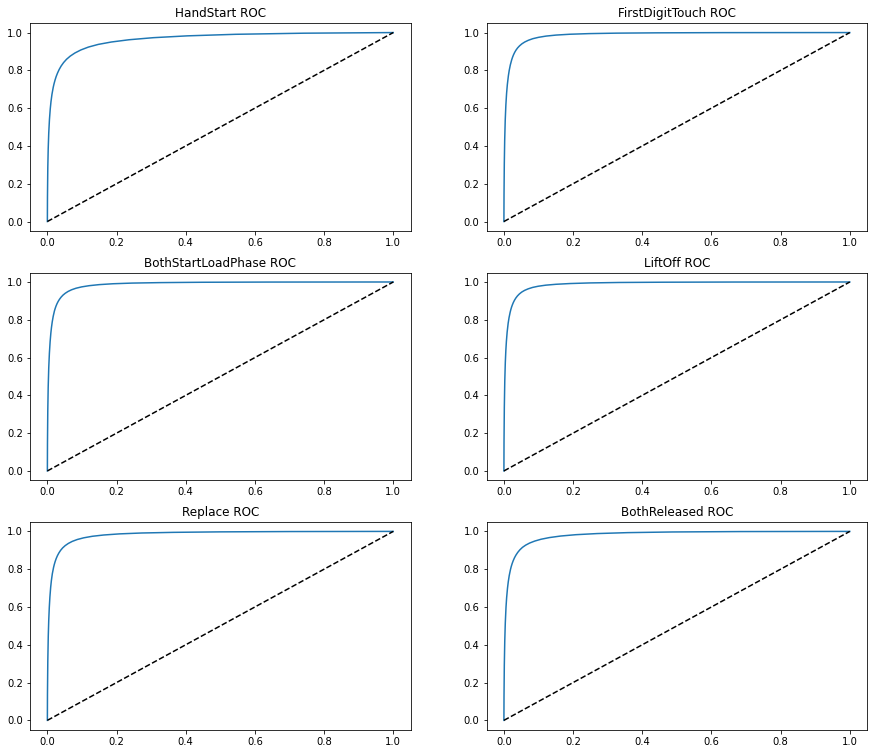

In [ ]:
y_pred = np.concatenate(pred_train_tot, axis=0)
y_true = np.concatenate(y_list, axis=0)
plot_roc(y_true.T, y_pred.T)
print('AUC ROC score : ', metrics.roc_auc_score(y_true, y_pred))

In [ ]:
try:
  !rm submission.csv
except:
  pass
submission = pd.DataFrame(index=np.concatenate(ids_tot),
                          columns=cols,
                          data=np.concatenate(pred_tot))
submission.to_csv('submission.csv',index_label='id',float_format='%.3f')
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions submit -c grasp-and-lift-eeg-detection -f submission.csv -m "RF with triple stacked butter"

100% 171M/171M [00:09<00:00, 19.6MB/s]
Successfully submitted to Grasp-and-Lift EEG Detection

#### ROC Score for hidden data on Kaggle: 0.80557

### 5. Support Vector Machines

In [ ]:
ids_tot = []
pred_tot = []
y_list = []
pred_train_tot = []
preproc_mode = 2

for subject in subjects:
    X_train_denoised = []
    X_test_denoised = []
    y_raw= []
    raw = []
    fnames = sorted(glob('train/subj%d_series*_data.csv' % (subject)))
    for fname in fnames:
      data,labels=prepare_data(fname, True)
      raw.append(data)
      y_raw.append(labels)
        
    tnames = sorted(glob('test/subj%d_series*_data.csv' % (subject)))
    raw_t = []
    idx = []
    for fname in tnames:
      data = prepare_data(fname, False)
      raw_t.append(data)
      idx.append(np.array(data['id']))

    X_test= pd.concat(raw_t)
    ids=np.concatenate(idx)
    ids_tot.append(ids)
   
    X_test = X_test.drop(['id'], axis=1)
    X_test = np.asarray(X_test.astype(float))
    X_train = np.asarray(pd.concat(raw).astype(float))
    y_train = np.asarray(pd.concat(y_raw).astype(float))
    y_list.append(y_train)
    
    fs = 500.0
    lowcut = 7.0
    
    if (preproc_mode == 0):
      for i in range(0,32):      #Butter lowpass filter
          X_train_denoised.append(butter_lowpass_filter(X_train[:,i], lowcut, fs, order=3))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(butter_lowpass_filter(X_test[:,i], lowcut, fs, order=3))
          X_test_denoised = np.array(X_test_denoised).T
    elif (preproc_mode == 1):
      for i in range(0,32):      #Wavelet denoising
          X_train_denoised.append(wavelet_denoising(X_train[:,i]))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(wavelet_denoising(X_test[:,i]))
          X_test_denoised = np.array(X_test_denoised).T
    else:   #Stack butter features
      X_train_denoised = stack_butter_features(X_train)
      X_test_denoised = stack_butter_features(X_test)
        

    X_train = scaler.fit_transform(X_train_denoised)
    X_test = scaler.transform(X_test_denoised)

    clf = svm.SVC(probability=True)
    pred = np.empty((X_test.shape[0], 6))
    pred_t = np.empty((X_train.shape[0], 6))

    for i in range(6):
      y = y_train[:, i]
      print('Train subject %d, class %s' % (subject, cols[i]))
      clf.fit(X_train[::downsample,:],y[::downsample])
      pred[:,i] = clf.predict_proba(X_test)[:,1]
      pred_t[:, i] = clf.predict_proba(X_train)[:,1]
    pred_train_tot.append(pred_t)
    pred_tot.append(pred)

In [ ]:
try:
  !rm submission.csv
except:
  pass
submission = pd.DataFrame(index=np.concatenate(ids_tot),
                          columns=cols,
                          data=np.concatenate(pred_tot))
submission.to_csv('submission.csv',index_label='id',float_format='%.3f')
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions submit -c grasp-and-lift-eeg-detection -f submission.csv -m "SVM with triple stacked butter"

100% 171M/171M [00:13<00:00, 12.9MB/s]
Successfully submitted to Grasp-and-Lift EEG Detection

#### ROC Score for hidden data on Kaggle: 0.82638



### 6. PCA with Random Forests

In [ ]:
columns = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9',
           'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']

ids_tot = []
pred_tot = []
y_list = []
pred_train_tot = []
preproc_mode = 2
compdata = []
pca = PCA(n_components=10)
for subject in subjects:
    X_train_denoised = []
    X_test_denoised = []
    y_raw= []
    raw = []
    fnames = sorted(glob('train/subj%d_series*_data.csv' % (subject)))
    for fname in fnames:
      data,labels=prepare_data(fname, True)
      raw.append(data)
      y_raw.append(labels)
        
    tnames = sorted(glob('test/subj%d_series*_data.csv' % (subject)))
    raw_t = []
    idx = []
    for fname in tnames:
      data = prepare_data(fname, False)
      raw_t.append(data)
      idx.append(np.array(data['id']))

    X_test= pd.concat(raw_t)
    ids=np.concatenate(idx)
    ids_tot.append(ids)
   
    X_test = X_test.drop(['id'], axis=1)
    X_test = np.asarray(X_test.astype(float))
    X_train = np.asarray(pd.concat(raw).astype(float))
    y_train = np.asarray(pd.concat(y_raw).astype(float))
    y_list.append(y_train)
    
    fs = 500.0
    lowcut = 7.0
    
    if (preproc_mode == 0):
      for i in range(0,32):      #Butter lowpass filter
          X_train_denoised.append(butter_lowpass_filter(X_train[:,i], lowcut, fs, order=3))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(butter_lowpass_filter(X_test[:,i], lowcut, fs, order=3))
          X_test_denoised = np.array(X_test_denoised).T
    elif (preproc_mode == 1):
      for i in range(0,32):      #Wavelet denoising
          X_train_denoised.append(wavelet_denoising(X_train[:,i]))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(wavelet_denoising(X_test[:,i]))
          X_test_denoised = np.array(X_test_denoised).T
    else:   #Stack butter features
      X_train_denoised = stack_butter_features(X_train)
      X_test_denoised = stack_butter_features(X_test)
  
        

    X_train = scaler.fit_transform(X_train_denoised)
    X_test = scaler.transform(X_test_denoised)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    compdata.append(np.argmax(pca.components_, axis=1))

    rf = RandomForestClassifier(n_estimators=150, n_jobs=-1, criterion="entropy", random_state=1)
    pred = np.empty((X_test.shape[0], 6))
    pred_t = np.empty((X_train.shape[0], 6))

    for i in range(6):
      y = y_train[:, i]
      print('Train subject %d, class %s' % (subject, cols[i]))
      rf.fit(X_train[::downsample,:],y[::downsample])
      pred[:,i] = rf.predict_proba(X_test)[:,1]
      pred_t[:, i] = rf.predict_proba(X_train)[:,1]
    pred_train_tot.append(pred_t)
    pred_tot.append(pred)

#### ROC Curves of training data

AUC ROC score :  0.8870008650517757


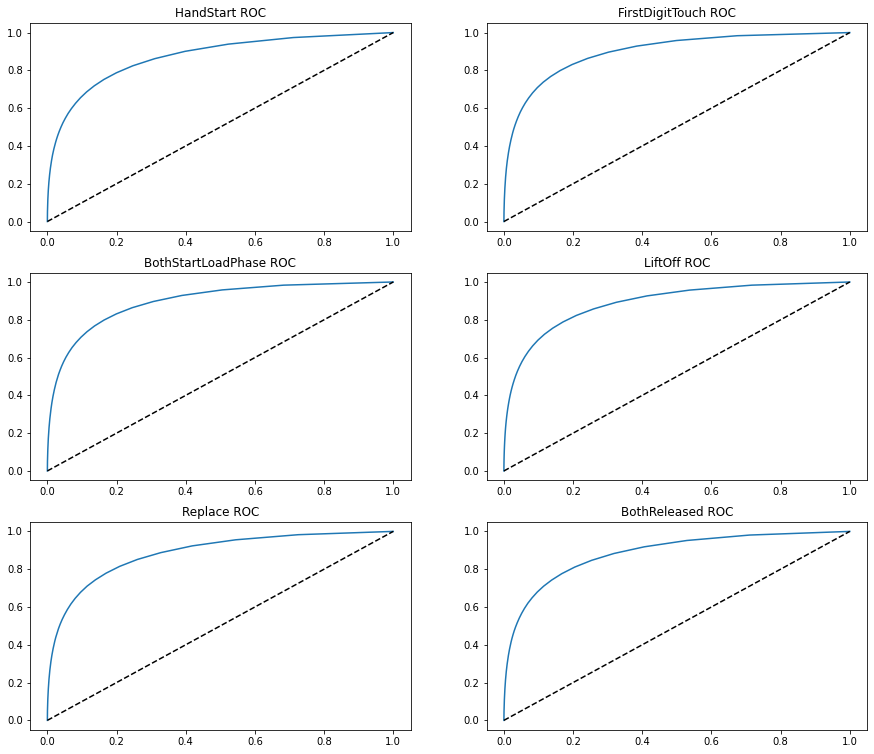

In [ ]:
y_pred = np.concatenate(pred_train_tot, axis=0)
y_true = np.concatenate(y_list, axis=0)
plot_roc(y_true.T, y_pred.T)
print('AUC ROC score : ', metrics.roc_auc_score(y_true, y_pred))

In [ ]:
pd.DataFrame(pca.components_)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91
0,0.159480,0.152671,0.114252,-0.015072,-0.001055,0.006074,0.155345,0.012535,0.048009,-0.016605,0.038614,0.007125,0.016383,-0.012872,-0.004274,0.000039,0.007545,0.009101,0.007597,-0.005515,0.005137,0.057805,0.005412,0.010427,-0.004729,0.001589,0.002691,0.008220,0.005009,-0.000241,-0.006334,-0.003082,0.158731,0.168934,0.173798,0.175666,0.175978,0.175584,0.174865,0.174010,...,0.143479,0.153380,0.157980,0.160039,0.160855,0.161070,0.160965,0.160686,0.160321,0.159922,0.080400,0.088704,0.094233,0.096869,0.097820,0.098058,0.097988,0.097774,0.097496,0.097196,0.110895,0.114218,0.116044,0.117323,0.118069,0.118448,0.118592,0.118593,0.118510,0.118382,0.028659,0.030650,0.031899,0.032738,0.033262,0.033575,0.033752,0.033844,0.033884,0.033891
1,-0.035019,-0.062192,-0.131836,0.062318,-0.036045,-0.049146,-0.069332,-0.017195,0.027033,0.037440,-0.018587,-0.003252,-0.015763,-0.005236,-0.033105,-0.008140,0.004247,-0.004379,-0.007995,-0.023976,-0.017113,-0.019595,-0.024646,-0.033445,-0.029901,-0.018464,-0.007487,-0.026785,-0.013460,0.007723,-0.008966,-0.016235,-0.038360,-0.040665,-0.038789,-0.038291,-0.038620,-0.038986,-0.039166,-0.039168,...,-0.065571,-0.068187,-0.067093,-0.066442,-0.066301,-0.066268,-0.066181,-0.066026,-0.065827,-0.065608,0.158986,0.169942,0.176282,0.179669,0.181001,0.181319,0.181109,0.180612,0.179973,0.179277,-0.133024,-0.137454,-0.138157,-0.138407,-0.138407,-0.138247,-0.138003,-0.137723,-0.137431,-0.137144,0.125481,0.126597,0.127247,0.127753,0.128080,0.128260,0.128334,0.128332,0.128281,0.128206
2,-0.063171,-0.050492,0.052716,0.038791,-0.026507,0.049089,0.035890,0.118269,0.010408,0.082959,0.118254,0.167440,0.198816,0.097798,0.189722,0.132266,0.218374,0.192537,0.193821,0.054792,0.188427,0.162131,0.196679,0.260757,0.226982,0.245566,0.203191,0.212841,0.276371,0.257481,0.256410,0.194350,-0.006221,-0.013961,-0.022031,-0.029150,-0.034413,-0.038426,-0.041603,-0.044150,...,-0.020198,-0.023865,-0.029648,-0.033486,-0.035933,-0.037769,-0.039297,-0.040585,-0.041663,-0.042571,0.022422,0.024239,0.023325,0.022107,0.021424,0.021036,0.020767,0.020573,0.020431,0.020317,0.046157,0.047877,0.052536,0.052997,0.052066,0.050940,0.049949,0.049135,0.048471,0.047925,0.050748,0.050628,0.051708,0.051743,0.051617,0.051479,0.051327,0.051165,0.051013,0.050881
3,-0.019638,-0.025314,0.111295,0.002636,0.002059,-0.011277,0.013702,-0.002101,0.004966,-0.028018,-0.031463,-0.039084,-0.038189,-0.006011,-0.063111,-0.045823,-0.031908,-0.012515,-0.034028,-0.052833,-0.059609,-0.044102,-0.040521,-0.061620,-0.071220,-0.063434,-0.057986,-0.041584,-0.065692,-0.057033,-0.069430,-0.059067,-0.017570,-0.025020,-0.027360,-0.027857,-0.027300,-0.026498,-0.025753,-0.025134,...,-0.026807,-0.030559,-0.031140,-0.031159,-0.030846,-0.030411,-0.029972,-0.029575,-0.029229,-0.028926,-0.022970,-0.032223,-0.038058,-0.041042,-0.042330,-0.042838,-0.042959,-0.042878,-0.042694,-0.042464,0.113227,0.117840,0.117961,0.118154,0.118364,0.118451,0.118419,0.118310,0.118160,0.117991,0.252453,0.261188,0.262407,0.262567,0.262382,0.262058,0.261686,0.261310,0.260947,0.260607
4,0.031393,0.136642,-0.168014,-0.178160,0.037219,0.032521,-0.122158,0.032591,0.002170,-0.021108,0.018998,0.054215,0.017173,-0.041042,0.029532,0.055229,-0.013698,0.048548,-0.010794,0.045687,0.013487,0.011589,0.048923,0.052507,0.050749,0.070561,0.042215,0.023204,0.044775,0.051602,0.071557,0.057803,0.038300,0.044443,0.044348,0.044269,0.044110,0.043759,0.043250,0.042646,...,0.142748,0.148917,0.148953,0.148900,0.148816,0.148541,0.148087,0.147528,0.146925,0.146315,-0.140289,-0.145712,-0.146967,-0.147426,-0.147345,-0.146996,-0.146512,-0.145957,-0.145371,-0.144783,-0.169995,-0.173613,-0.174110,-0.174075,-0.173986,-0.173887,-0.173771,-0.173653,-0.173546,-0.173455,0.099760,0.103614,0.104743,0.105301,0.105513,0.105561,0.1

In [ ]:
df = pd.DataFrame(compdata, columns = ['Imp 1', 'Imp 2', 'Imp 3', 'Imp 4', 'Imp 5', 'Imp 6', 'Imp 7', 'Imp 8', 'Imp 9', 'Imp 10', 'Imp 11', 'Imp 12'])
df

,Imp 1,Imp 2,Imp 3,Imp 4,Imp 5,Imp 6,Imp 7,Imp 8,Imp 9,Imp 10,Imp 11,Imp 12
0,87,38,47,24,71,1,52,50,55,10,6,27
1,37,49,86,43,84,70,61,45,52,6,3,8
2,57,84,46,19,32,14,52,7,13,42,5,3
3,78,65,49,75,67,52,91,11,3,8,3,17
4,38,62,86,45,69,68,9,51,21,4,0,3
5,78,69,85,44,48,19,5,32,62,18,11,14
6,37,68,68,84,91,4,45,8,32,66,9,53
7,88,48,48,61,91,40,4,6,32,65,10,11
8,36,46,28,85,42,5,4,40,5,3,19,82
9,78,48,30,70,88,44,51,41,24,32,33,15


In [ ]:
try:
  !rm submission.csv
except:
  pass
submission = pd.DataFrame(index=np.concatenate(ids_tot),
                        columns=cols,
                        data=np.concatenate(pred_tot))
submission.to_csv('submission.csv',index_label='id',float_format='%.3f')
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions submit -c grasp-and-lift-eeg-detection -f submission.csv -m "RF with PCA & triple stacked butter"

rm: cannot remove 'submission.csv': No such file or directory
100% 171M/171M [00:13<00:00, 13.2MB/s]
Successfully submitted to Grasp-and-Lift EEG Detection

#### ROC Score for hidden data on Kaggle: 0.65264

### 7.  Ensemble of LDA + Random Forest + Logistic Regression

In [ ]:
ids_tot = []
pred_tot = []
y_list = []
pred_train_tot = []
preproc_mode = 2

for subject in subjects:
    X_train_denoised = []
    X_test_denoised = []
    y_raw= []
    raw = []
    fnames = sorted(glob('train/subj%d_series*_data.csv' % (subject)))
    for fname in fnames:
      data,labels=prepare_data(fname, True)
      raw.append(data)
      y_raw.append(labels)
        
    tnames = sorted(glob('test/subj%d_series*_data.csv' % (subject)))
    raw_t = []
    idx = []
    for fname in tnames:
      data = prepare_data(fname, False)
      raw_t.append(data)
      idx.append(np.array(data['id']))

    X_test= pd.concat(raw_t)
    ids=np.concatenate(idx)
    ids_tot.append(ids)
   
    X_test = X_test.drop(['id'], axis=1)
    X_test = np.asarray(X_test.astype(float))
    X_train = np.asarray(pd.concat(raw).astype(float))
    y_train = np.asarray(pd.concat(y_raw).astype(float))
    y_list.append(y_train)
    
    fs = 500.0
    lowcut = 7.0
    
    if (preproc_mode == 0):
      for i in range(0,32):      #Butter lowpass filter
          X_train_denoised.append(butter_lowpass_filter(X_train[:,i], lowcut, fs, order=3))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(butter_lowpass_filter(X_test[:,i], lowcut, fs, order=3))
          X_test_denoised = np.array(X_test_denoised).T
    elif (preproc_mode == 1):
      for i in range(0,32):      #Wavelet denoising
          X_train_denoised.append(wavelet_denoising(X_train[:,i]))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(wavelet_denoising(X_test[:,i]))
          X_test_denoised = np.array(X_test_denoised).T
    else:   #Stack butter features
      X_train_denoised = stack_butter_features(X_train)
      X_test_denoised = stack_butter_features(X_test)
        

    X_train = scaler.fit_transform(X_train_denoised)
    X_test = scaler.transform(X_test_denoised)

    model1 = LDA()
    model2 = LogisticRegression()
    model3 = RandomForestClassifier(n_estimators=150, n_jobs=-1, criterion="entropy", random_state=1)
    pred = np.empty((X_test.shape[0],6))

    pred_t = np.empty((X_train.shape[0], 6))
    for i in range(6):
      y = y_train[:, i]
      print('Train subject %d, class %s' % (subject, cols[i]))
      model1.fit(X_train[::downsample,:],y[::downsample])
      model2.fit(X_train[::downsample,:],y[::downsample])
      model3.fit(X_train[::downsample,:],y[::downsample])

      pred[:, i] = ((model1.predict_proba(X_test)[:,1])*0.4
                  +(model2.predict_proba(X_test)[:,1])*0.35
                  +(model3.predict_proba(X_test)[:,1])*0.25)

      pred_t[:, i] = ((model1.predict_proba(X_train)[:,1])*0.4
                    +(model2.predict_proba(X_train)[:,1])*0.35
                    +(model3.predict_proba(X_train)[:,1])*0.25)
    pred_tot.append(pred)
    pred_train_tot.append(pred_t)

#### ROC Curves of training data

AUC ROC score :  0.9601044814714378


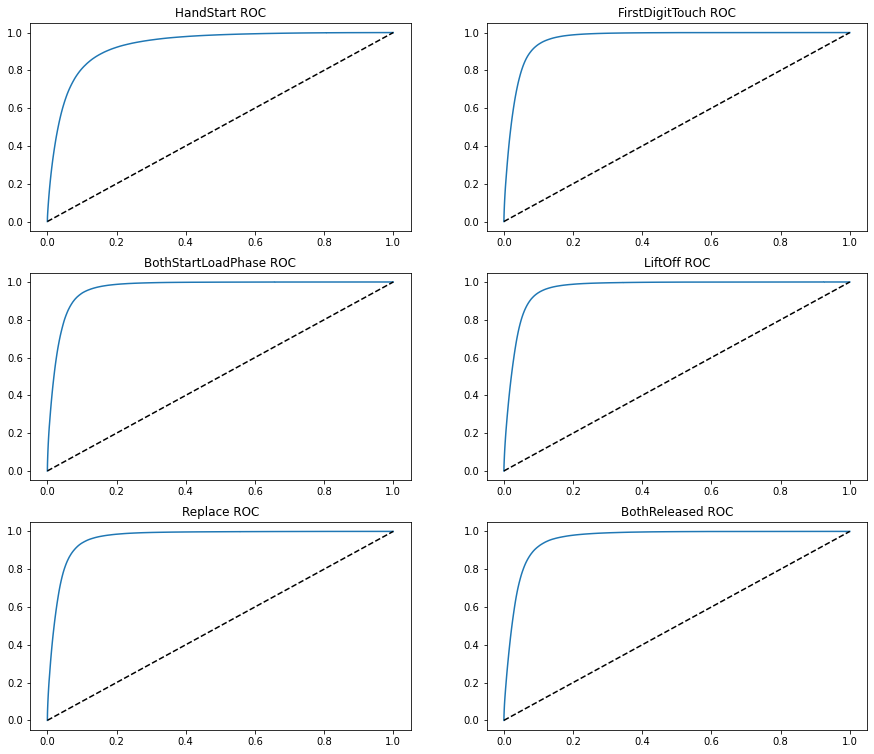

In [ ]:
y_pred = np.concatenate(pred_train_tot, axis=0)
y_true = np.concatenate(y_list, axis=0)
plot_roc(y_true.T, y_pred.T)
print('AUC ROC score : ', metrics.roc_auc_score(y_true, y_pred))

In [ ]:
try:
  !rm submission.csv
except:
  pass
submission = pd.DataFrame(index=np.concatenate(ids_tot),
                        columns=cols,
                        data=np.concatenate(pred_tot))
submission.to_csv('submission.csv',index_label='id',float_format='%.3f')
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions submit -c grasp-and-lift-eeg-detection -f submission.csv -m "Ensemble (LDA + Random Forest + LR) with stacked butter"

100% 171M/171M [00:12<00:00, 14.1MB/s]
Successfully submitted to Grasp-and-Lift EEG Detection

#### ROC Score for hidden data on Kaggle: 0.88507



### 8. Ensemble of LDA + Logistic Regression

In [ ]:
ids_tot = []
pred_tot = []
y_list = []
pred_train_tot = []
preproc_mode = 2

for subject in subjects:
    X_train_denoised = []
    X_test_denoised = []
    y_raw= []
    raw = []
    fnames = sorted(glob('train/subj%d_series*_data.csv' % (subject)))
    for fname in fnames:
      data,labels=prepare_data(fname, True)
      raw.append(data)
      y_raw.append(labels)
        
    tnames = sorted(glob('test/subj%d_series*_data.csv' % (subject)))
    raw_t = []
    idx = []
    for fname in tnames:
      data = prepare_data(fname, False)
      raw_t.append(data)
      idx.append(np.array(data['id']))

    X_test= pd.concat(raw_t)
    ids=np.concatenate(idx)
    ids_tot.append(ids)
   
    X_test = X_test.drop(['id'], axis=1)
    X_test = np.asarray(X_test.astype(float))
    X_train = np.asarray(pd.concat(raw).astype(float))
    y_train = np.asarray(pd.concat(y_raw).astype(float))
    y_list.append(y_train)
    
    fs = 500.0
    lowcut = 7.0
    
    if (preproc_mode == 0):
      for i in range(0,32):      #Butter lowpass filter
          X_train_denoised.append(butter_lowpass_filter(X_train[:,i], lowcut, fs, order=3))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(butter_lowpass_filter(X_test[:,i], lowcut, fs, order=3))
          X_test_denoised = np.array(X_test_denoised).T
    elif (preproc_mode == 1):
      for i in range(0,32):      #Wavelet denoising
          X_train_denoised.append(wavelet_denoising(X_train[:,i]))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(wavelet_denoising(X_test[:,i]))
          X_test_denoised = np.array(X_test_denoised).T
    else:   #Stack butter features
      X_train_denoised = stack_butter_features(X_train)
      X_test_denoised = stack_butter_features(X_test)
        

    X_train = scaler.fit_transform(X_train_denoised)
    X_test = scaler.transform(X_test_denoised)

    model1 = LDA()
    model2 = LogisticRegression()
    pred = np.empty((X_test.shape[0],6))

    pred_t = np.empty((X_train.shape[0], 6))
    for i in range(6):
      y = y_train[:, i]
      print('Train subject %d, class %s' % (subject, cols[i]))
      model1.fit(X_train[::downsample,:],y[::downsample])
      model2.fit(X_train[::downsample,:],y[::downsample])

      pred[:, i] = ((model1.predict_proba(X_test)[:,1])*0.5
                  +(model2.predict_proba(X_test)[:,1])*0.5)

      pred_t[:, i] = ((model1.predict_proba(X_train)[:,1])*0.5
                    +(model2.predict_proba(X_train)[:,1])*0.5)
    pred_tot.append(pred)
    pred_train_tot.append(pred_t)

#### ROC Curves of training data

AUC ROC score :  0.9123931997409617


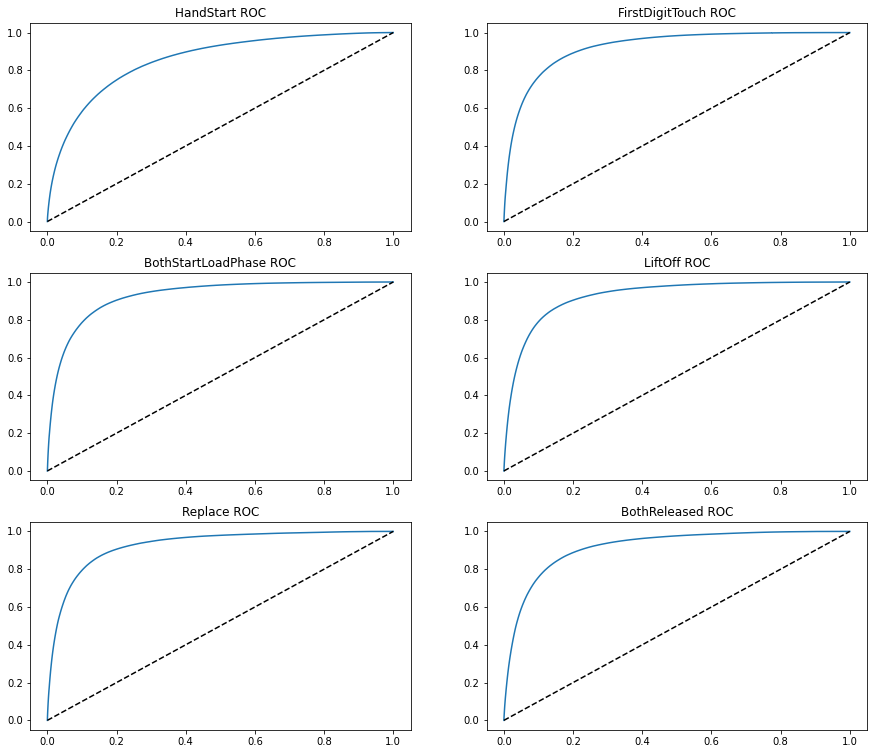

In [ ]:
y_pred = np.concatenate(pred_train_tot, axis=0)
y_true = np.concatenate(y_list, axis=0)
plot_roc(y_true.T, y_pred.T)
print('AUC ROC score : ', metrics.roc_auc_score(y_true, y_pred))

In [ ]:
try:
  !rm submission.csv
except:
  pass
submission = pd.DataFrame(index=np.concatenate(ids_tot),
                        columns=cols,
                        data=np.concatenate(pred_tot))
submission.to_csv('submission.csv',index_label='id',float_format='%.3f')
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions submit -c grasp-and-lift-eeg-detection -f submission.csv -m "Ensemble (LDA + LR) with stacked butter"

rm: cannot remove 'submission.csv': No such file or directory
100% 171M/171M [00:07<00:00, 25.1MB/s]
Successfully submitted to Grasp-and-Lift EEG Detection

#### ROC Score for hidden data on Kaggle: 0.88658

### 9. Ensemble of RF + Logistic Regression + QDA + LDA 

In [ ]:
ids_tot = []
pred_tot = []
y_list = []
pred_train_tot = []
preproc_mode = 2

for subject in subjects:
    X_train_denoised = []
    X_test_denoised = []
    y_raw= []
    raw = []
    fnames = sorted(glob('train/subj%d_series*_data.csv' % (subject)))
    for fname in fnames:
      data,labels=prepare_data(fname, True)
      raw.append(data)
      y_raw.append(labels)
        
    tnames = sorted(glob('test/subj%d_series*_data.csv' % (subject)))
    raw_t = []
    idx = []
    for fname in tnames:
      data = prepare_data(fname, False)
      raw_t.append(data)
      idx.append(np.array(data['id']))

    X_test= pd.concat(raw_t)
    ids=np.concatenate(idx)
    ids_tot.append(ids)
   
    X_test = X_test.drop(['id'], axis=1)
    X_test = np.asarray(X_test.astype(float))
    X_train = np.asarray(pd.concat(raw).astype(float))
    y_train = np.asarray(pd.concat(y_raw).astype(float))
    y_list.append(y_train)
    
    fs = 500.0
    lowcut = 7.0
    
    if (preproc_mode == 0):
      for i in range(0,32):      #Butter lowpass filter
          X_train_denoised.append(butter_lowpass_filter(X_train[:,i], lowcut, fs, order=3))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(butter_lowpass_filter(X_test[:,i], lowcut, fs, order=3))
          X_test_denoised = np.array(X_test_denoised).T
    elif (preproc_mode == 1):
      for i in range(0,32):      #Wavelet denoising
          X_train_denoised.append(wavelet_denoising(X_train[:,i]))
          X_train_denoised = np.array(X_train_denoised).T
          X_test_denoised.append(wavelet_denoising(X_test[:,i]))
          X_test_denoised = np.array(X_test_denoised).T
    else:   #Stack butter features
      X_train_denoised = stack_butter_features(X_train)
      X_test_denoised = stack_butter_features(X_test)
        

    X_train = scaler.fit_transform(X_train_denoised)
    X_test = scaler.transform(X_test_denoised)

    model1 = LDA()
    model2 = LogisticRegression()
    model3 = RandomForestClassifier(n_estimators=150, n_jobs=-1, criterion="entropy", random_state=1)
    model4 = QDA()
    
    pred = np.empty((X_test.shape[0],6))
    pred_t = np.empty((X_train.shape[0], 6))

    for i in range(6):
      y = y_train[:, i]
      print('Train subject %d, class %s' % (subject, cols[i]))
      model1.fit(X_train[::downsample,:],y[::downsample])
      model2.fit(X_train[::downsample,:],y[::downsample])
      model3.fit(X_train[::downsample,:],y[::downsample])
      model4.fit(X_train[::downsample,:],y[::downsample])

      pred[:, i] = ((model1.predict_proba(X_test)[:,1])*0.3
                  +(model2.predict_proba(X_test)[:,1])*0.3
                  +(model3.predict_proba(X_test)[:,1])*0.25
                  +(model4.predict_proba(X_test)[:,1])*0.15)

      pred_t[:, i] = ((model1.predict_proba(X_train)[:,1])*0.3
                    +(model2.predict_proba(X_train)[:,1])*0.3
                    +(model3.predict_proba(X_train)[:,1])*0.25
                    +(model4.predict_proba(X_train)[:,1])*0.15)
    pred_tot.append(pred)
    pred_train_tot.append(pred_t)

#### ROC Curves of training data

AUC ROC score :  0.96310252895838


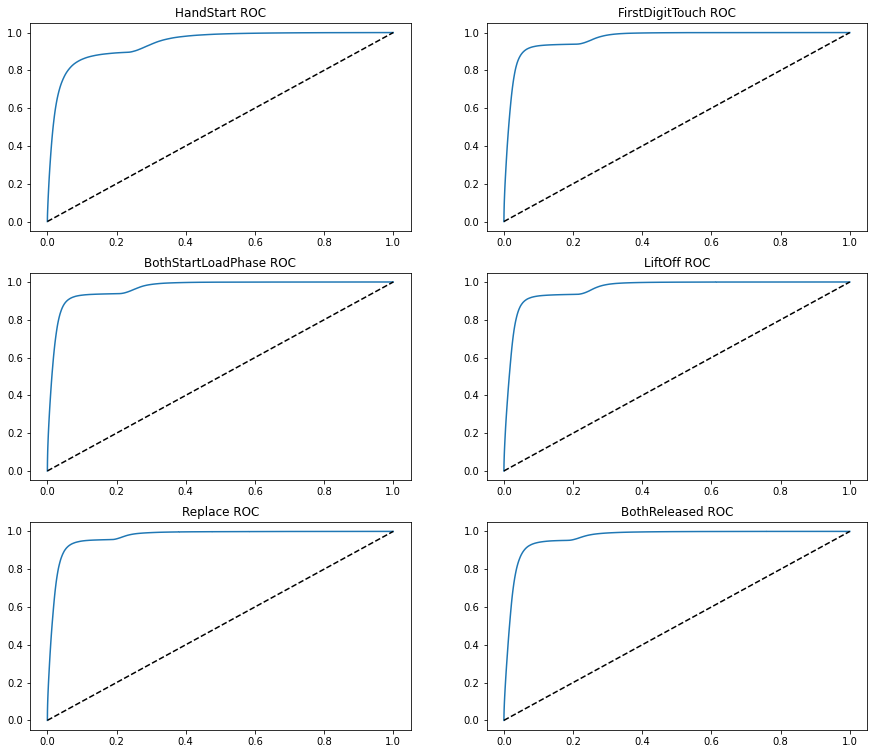

In [ ]:
y_pred = np.concatenate(pred_train_tot, axis=0)
y_true = np.concatenate(y_list, axis=0)
plot_roc(y_true.T, y_pred.T)
print('AUC ROC score : ', metrics.roc_auc_score(y_true, y_pred))

In [ ]:
try:
  !rm submission.csv
except:
  pass
submission = pd.DataFrame(index=np.concatenate(ids_tot),
                        columns=cols,
                        data=np.concatenate(pred_tot))
submission.to_csv('submission.csv',index_label='id',float_format='%.3f')
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions submit -c grasp-and-lift-eeg-detection -f submission.csv -m "Ensemble (LDA + QDA + LR + RF) with Butter Lowpass"

100% 171M/171M [00:08<00:00, 22.1MB/s]
Successfully submitted to Grasp-and-Lift EEG Detection

#### ROC Score for hidden data on Kaggle: 0.86189

## Code Walkthrough

Here, we provide a code walkthrough of the CNN implementation that we have used for our problem.

The `read_csv` function handles the data import and it grabs all the $.csv$ files that are required for the training and testing loops. It imports the data from the 32 electrodes that make up the 32 features and it also gets the labels for the 6 actions that are one-hot encoded. We use the last two series of every subject for validation. 

The `resample_data` function is used to create chunks of data of size 1000 and this is necessary as every row in the data captures a span of around 75ms and that means that the data in rows next to each other is highly correlated. We also discard a lot of chunks in this function as most of them do not have any event occuring in them and this really helped the model as a lot of noise was discarded in this way and it was computationally cheaper as well. We ended up eliminating almost 50\% of the data by using this method. We also standardize the data in the `EEGSignalDataset` class.

We have used a deep neural network architecture for the problem here as the data is extremely complex and the model needs depth to extract the right features that will be useful for the classification task. The model contains 23 layers including the activation functions (Sigmoid Linear Unit), 1-D convolutions and Max pooling layers (Stride 2). The parameters of all the layers have been printed in a code block below.

When it comes to hyperparameters, we have used an Adam optimizer with a $lr=0.002$ loss and binary Cross Entropy loss. We have only trained the model for one epoch as that was sufficient due to the large size of the data. After training, we plot the ROC curves for the validation dataset and also iterate through the test data to create the $.csv$ file that is needed for a submission on Kaggle. We need to do this to check our model on the testing set as the labels for testing set are not available to us and are hidden on Kaggle. We get a final accuracy of 92.35\% on the testing set.

### 10. Convolutional Neural Network

In [ ]:
def read_csv(data, events):
    x = pd.read_csv(data)
    y = pd.read_csv(events)
    id = '_'.join(x.iloc[0, 0].split('_')[:-1])
    x = x.iloc[:,1:].values
    y = y.iloc[:,1:].values
    return x, y
trainset = []
gt = []
for filename in tqdm(os.listdir('./train')):
    if 'data' in filename:
        data_file_name = os.path.join('./train', filename)
        id = filename.split('.')[0]
        events_file_name = os.path.join('./train', '_'.join(id.split('_')[:-1]) + '_events.csv')
        x, y = read_csv(data_file_name, events_file_name)
        trainset.append(x.T.astype(np.float32))
        gt.append(y.T.astype(np.float32))

valid_dataset = trainset[-2:]
valid_gt = gt[-2:]
trainset = trainset[:-2]
gt = gt[:-2]
torch.manual_seed(2021)
np.random.seed(2021)
in_len = 2**10
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

  0%|          | 0/192 [00:00<?, ?it/s]

cuda:0


In [ ]:
def resample_data(gt, chunk_size=1000):
    """
    split long signals to smaller chunks, discard no-events chunks  
    """
    total_discard_chunks = 0
    mean_val = []
    threshold = 0.01
    index = []
    
    for i in range(len(gt)):
        for j in range(0, gt[i].shape[1], chunk_size):
            mean_val.append(np.mean(gt[i][:, j:min(gt[i].shape[1],j+chunk_size)]))
            if mean_val[-1] < threshold:  # discard chunks with low events time
                total_discard_chunks += 1
            else:
                index.extend([(i, k) for k in range(j, min(gt[i].shape[1],j+chunk_size))])

    print('Total number of chunks discarded: {} chunks'.format(total_discard_chunks))
    print('{:.2f}% data was discarded.'.format((total_discard_chunks*100)/len(mean_val)))
    del mean_val
    gc.collect()
    return index

In [ ]:
class EEGSignalDataset(Dataset):
    def __init__(self, data, gt, m=0, s=1, soft_label=True, train=True):
        self.data = data
        self.gt = gt
        self.train = train
        self.soft_label = soft_label
        self.eps = 1e-7

        if train:
            self.index = resample_data(gt)
        else:
            self.index = [(i, j) for i in range(len(data)) for j in range(data[i].shape[1])]
        for dt in self.data:
            dt -= m
            dt /= s + self.eps
    
    def __getitem__(self, i):
        i, j = self.index[i]
        raw_data, label = self.data[i][:,max(0, j-in_len+1):j+1], \
                self.gt[i][:,j]
        
        pad = in_len - raw_data.shape[1]
        if pad:
            raw_data = np.pad(raw_data, ((0,0),(pad,0)), 'constant',constant_values=0)

        raw_data, label = torch.from_numpy(raw_data.astype(np.float32)),\
                            torch.from_numpy(label.astype(np.float32))
        if self.soft_label:
            label[label < .02] = .02

        return raw_data, label

    
    def __len__(self):
        return len(self.index)
    
dataset = EEGSignalDataset(trainset, gt) 
dataloader = DataLoader(dataset, batch_size = 1024,\
                                       num_workers = 1, shuffle=True)
print("Length of dataset = ", len(dataset))

Total number of chunks discarded: 8835 chunks
49.84% data was discarded.
Length of dataset =  8892000


In [ ]:
class NNet(nn.Module):
    def __init__(self, in_channels=32, out_channels=6):
        super(NNet, self).__init__()
        self.hidden = 32
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, in_channels, 5, padding=2),
            nn.Conv1d(in_channels, self.hidden, 16, stride=16),
            nn.SiLU(),
            nn.Conv1d(self.hidden, self.hidden, 7, padding=3),
        )
        for i in range(6):
            self.net.add_module('conv{}'.format(i), \
                                self.__block(self.hidden, self.hidden))
        self.net.add_module('final', nn.Sequential(
            nn.Conv1d(self.hidden, 12, 1),
            nn.Conv1d(12, out_channels, 1),
            nn.Sigmoid()
        ))
        
    def __block(self, inchannels, outchannels):
        return nn.Sequential(
            nn.MaxPool1d(2, 2),
            nn.Conv1d(inchannels, outchannels, 5, padding=2),
            nn.SiLU(),
            nn.Conv1d(outchannels, outchannels, 5, padding=2),
            nn.SiLU()
          )
    
    def forward(self, x):
        return self.net(x)
print(NNet())

NNet(
  (net): Sequential(
    (0): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): Conv1d(32, 32, kernel_size=(16,), stride=(16,))
    (2): SiLU()
    (3): Conv1d(32, 32, kernel_size=(7,), stride=(1,), padding=(3,))
    (conv0): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (2): SiLU()
      (3): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (4): SiLU()
    )
    (conv1): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (2): SiLU()
      (3): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (4): SiLU()
    )
    (conv2): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padd

In [ ]:
n_epochs = 1

nnet = NNet()
nnet.to(device)
loss_fnc = nn.BCELoss()
adam = optim.Adam(nnet.parameters(), lr=0.002, betas=(0.5, 0.99))
loss_his, train_loss = [], []
nnet.train()
for epoch in range(n_epochs):
    p_bar = tqdm(dataloader)
    for i, (x, y) in enumerate(p_bar):
        x, y = x.to(device), y.to(device)
        pred = nnet(x)
        loss = loss_fnc(pred.squeeze(dim=-1), y)
        adam.zero_grad()
        loss.backward()
        adam.step()
        train_loss.append(loss.item())
        p_bar.set_description('[Loss: {}]'.format(train_loss[-1]))
        if i % 50 == 0:
            loss_his.append(np.mean(train_loss))
            train_loss.clear()
    print('[Epoch {}/{}] [Loss: {}]'.format(epoch+1, n_epochs, loss_his[-1]))
    
torch.save(nnet.state_dict(), 'model.pt')

  0%|          | 0/8684 [00:00<?, ?it/s]

[Epoch 1/1] [Loss: 0.1701182046532631]


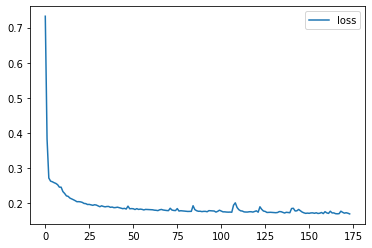

In [ ]:
plt.plot(range(len(loss_his)), loss_his, label='loss')
plt.legend()
plt.show()

#### Test on Validation set


In [ ]:
testset = EEGSignalDataset(valid_dataset, valid_gt, train=False, soft_label=False) 
testloader = DataLoader(testset, batch_size = 1024,\
                                       num_workers = 1, shuffle=False)
nnet.eval()
y_pred = []
with torch.no_grad():
    for x, _ in tqdm(testloader):
        x = x.to(device)
        pred = nnet(x).detach().cpu().numpy()
        y_pred.append(pred)

  0%|          | 0/296 [00:00<?, ?it/s]

#### ROC Curves of validation data

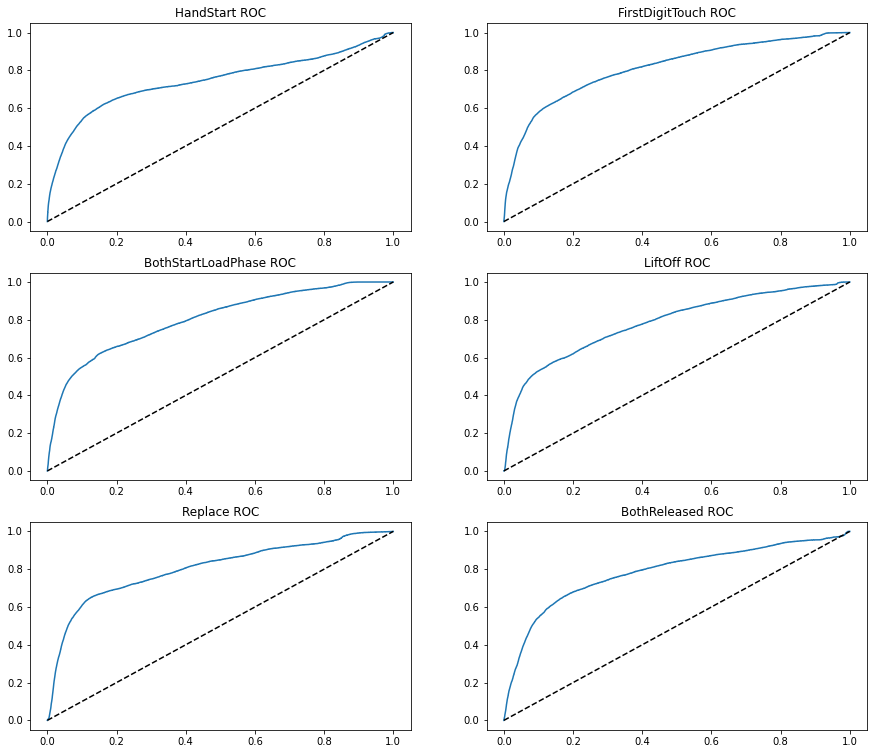

auc roc:  0.7889834905960437


In [ ]:
def plot_roc(y_true, y_pred):
    fig, axs = plt.subplots(3, 2, figsize=(15,13))
    for i, label in enumerate(cols):
        fpr, tpr, _ = metrics.roc_curve(y_true[i], y_pred[i])
        ax = axs[i//2, i%2]
        ax.plot(fpr, tpr)
        ax.set_title(label+" ROC")
        ax.plot([0, 1], [0, 1], 'k--')

    plt.show()
    
y_pred = np.concatenate(y_pred, axis=0).squeeze(axis=-1)
valid_gt = np.concatenate(valid_gt, axis=1)
plot_roc(valid_gt, y_pred.T)
print('auc roc: ', metrics.roc_auc_score(valid_gt.T, y_pred))

#### ROC Curves of training data

  0%|          | 0/8684 [00:00<?, ?it/s]

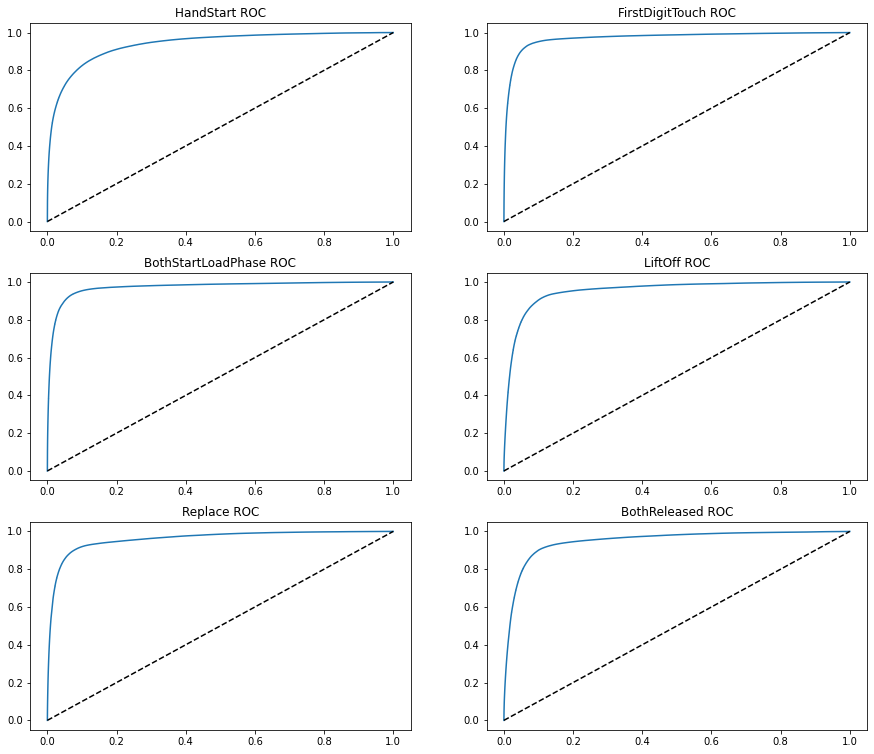

auc roc:  0.9573530679065098


In [ ]:
del y_pred
del testset
del testloader
del valid_dataset
del valid_gt
gc.collect()
y_pred = []
y_true = []
with torch.no_grad():
    for x, y in tqdm(dataloader):
        x = x.to(device)
        pred = nnet(x).squeeze(dim=-1).detach().cpu().numpy()
        y_pred.append(pred)
        y_true.append(y)
y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)
y_true[y_true<.1]=0
plot_roc(y_true.T, y_pred.T)
print('auc roc: ', metrics.roc_auc_score(y_true, y_pred))

In [ ]:
del y_pred
del y_true
del dataset
del dataloader
del trainset
del gt
gc.collect()

0

In [ ]:
class EEGSignalTestset(Dataset):
    def __init__(self, data, m, s):
        self.data = data
        self.eps = 1e-7
        self.data -= m
        self.data /= s+self.eps
    
    def __getitem__(self, i):

        raw_data = self.data[:,max(0, i-in_len+1):i+1]
        
        pad = in_len - raw_data.shape[1]
        if pad:
            raw_data = np.pad(raw_data, ((0,0),(pad,0)), 'constant',constant_values=0)

        raw_data = torch.from_numpy(raw_data.astype(np.float32))
        return raw_data
            
    
    def __len__(self):
        return self.data.shape[1]

testset = []
trial_len = {}
FNAME = "./test/subj{}_series{}_{}.csv"

for subj in range(1,13):
    for series in [9, 10]:
        data_file_name = FNAME.format(subj, series, 'data')
        x = pd.read_csv(data_file_name).iloc[:,1:].values
        testset.append(x.T.astype(np.float32))
        trial_len['{}_{}'.format(subj, series)] = testset[-1].shape[-1]
        
testset = np.concatenate(testset, axis=1)

In [ ]:
testset = EEGSignalTestset(testset, 0, 1)
dataloader = DataLoader(testset, batch_size = 1024,\
                                       num_workers = 1, shuffle=False)
y_pred = []
with torch.no_grad():
    for x in tqdm(dataloader):
        x = x.to(device)
        pred = nnet(x).detach().cpu().numpy()
        y_pred.append(pred)
        
y_pred = np.concatenate(y_pred, axis=0).squeeze(axis=-1)

  0%|          | 0/3071 [00:00<?, ?it/s]

In [ ]:
submission = pd.DataFrame(y_pred, index=\
    ['subj{}_series{}_{}'.format(sbj, i, j) for sbj in range(1,13) for i in [9,10] for j in range(trial_len['{}_{}'.format(sbj, i)])],\
                         columns=cols)
submission.to_csv('Submission-DL2-BN.csv',index_label='id',float_format='%.3f')
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions submit -c grasp-and-lift-eeg-detection -f Submission-DL2-BN.csv -m "Deep Learning experiments"

100% 171M/171M [00:11<00:00, 16.2MB/s]


#### ROC Score for hidden data on Kaggle: 0.92358

### Comparing our pre-processing methods: Wavelet Denoising vs Butter Lowpass filter

In [ ]:
data = [['LR', 'Butter Lowpass', 0.72848], 
        ['LR', 'Wavelet', 0.72057], 
        ['LR', 'Stacked Lowpass', 0.87406], 
        ['LR', 'Vanilla', 0.71479], 
        ['LDA', 'Butter Lowpass', 0.72428],
        ['LDA', 'Wavelet', 0.71732],
        ['LDA', 'Stacked Lowpass', 0.88596],
        ['LDA', 'Vanilla', 0.71124],
        ['QDA', 'Butter Lowpass', 0.66548],
        ['QDA', 'Wavelet', 0.66604],
        ['QDA', 'Stacked Lowpass', 0.72106],
        ['QDA', 'Vanilla', 0.65432],
        ['SVM', 'Butter Lowpass', 0.71887],
        ['SVM', 'Wavelet', 0.66887],
        ['SVM', 'Stacked Lowpass', 0.82638],
        ['SVM', 'Vanilla', 0.65508],
        ['RF', 'Butter Lowpass', 0.67852],
        ['RF', 'Wavelet', 0.71368],
        ['RF', 'Stacked Lowpass', 0.81046],
        ['RF', 'Vanilla', 0.69682],
        ['RF & PCA', 'Butter Lowpass', 0.65264],
        ['RF & PCA', 'Wavelet', 0.65625],
        ['RF & PCA', 'Stacked Lowpass', 0.65264],
        ['RF & PCA', 'Vanilla', 0.69682],
        ['LD+R+L', 'Butter Lowpass', 0.74772],
        ['LD+R+L', 'Stacked Lowpass', 0.88507],
        ['LD+L', 'Butter Lowpass', 0.74715],
        ['LD+L', 'Stacked Lowpass', 0.88658],
        ['LD+L+Q+R', 'Butter Lowpass', 0.74715],
        ['LD+L+Q+R', 'Stacked Lowpass', 0.86189],
        ['CNN', 'Raw', 0.92358]]

df = pd.DataFrame(data, columns = ['Algorithm', 'type', 'score'])

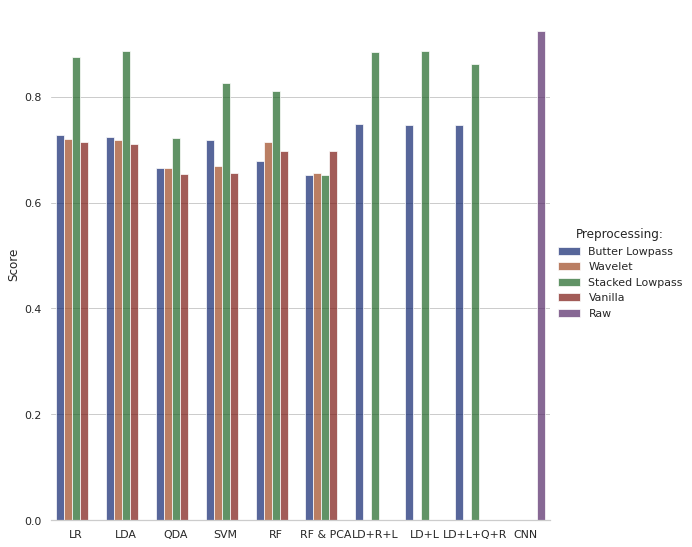

In [ ]:
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=df, kind="bar",
    x="Algorithm", y="score", hue="type",
    ci="sd", palette="dark", alpha=.7, height=8
)
g.despine(left=True)
g.set_axis_labels("", "Score")
g.legend.set_title("Preprocessing:")


###Observations

1. Stacked Lowpass filter performs better in all the models implemented. This is because it has 92 features - 32 raw features and 60 augmented features.

2. SiLU gives a better accuracy compared to the other activation functions in the CNN model.

3. Weighted ensembling based on the accuracy of individual models gave a better score compared to the individual models. At the same time, ensembling poor models with the good models gave a poor score.

4. Stacking features based on their feature importance obtained from PCA gave a better score than stacking random features.

5. Deep Learning did a better job on the dataset because, in our opinion, the depth of the model enables it to learn complex features from the data that are relevant to the predictions.
